In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
from numba_nsgev import seasonal_nsgev

In [2]:

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]


In [ ]:
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_MAR_MPI/les_season_max.npy')[:,:,jmin:jmax,imin:imax]

In [3]:
### Gumbel fit
@njit()
def gumbel_nllh(params,x):
    μ,σ = params
    s = (x-μ)/σ
    return np.sum(np.log(σ)+s+np.exp(-s))

@njit()
def fit_gumbel(x):
    '''
    Algorithm derived in this video : https://www.youtube.com/watch?v=p818JALlO44
    '''
    x_ = np.mean(x)
    σ = np.sqrt(np.sum((x-x_)**2)/(np.shape(x)[0]-1) *6)/np.pi
    if σ==0. or x_==np.nan:
        return np.array([ np.nan , np.nan])
    for i in range(4):
        e = np.exp(-x/σ)
        e_ = np.mean(e)
        xe_ = np.mean(x*e)
        σ -= (σ - x_ + xe_/e_) / (1+ ( e_*np.mean(x**2*e) - xe_**2 )/e_**2/σ**2)
    return np.array([ -σ*np.log(np.mean(np.exp(-x/σ))) , σ ])

@njit(parallel=True)
def seasonal_gumbel(les_season_max):
    nt,ns,nlat,nlon = np.shape(les_season_max)
    season_mu_sig = np.zeros((ns,nlat,nlon,2))
    season_nllh = np.zeros((ns,nlat,nlon))
    for s in prange(ns):
        for j in prange(nlat):
            for i in prange(nlon):
                season_mu_sig[s,j,i] = fit_gumbel(les_season_max[:,s,j,i])
                season_nllh[s,j,i] = gumbel_nllh(season_mu_sig[s,j,i],les_season_max[:,s,j,i])
    return season_mu_sig,season_nllh

In [4]:
season_mu_sig,season_nllh_gumbel = seasonal_gumbel(les_season_max)

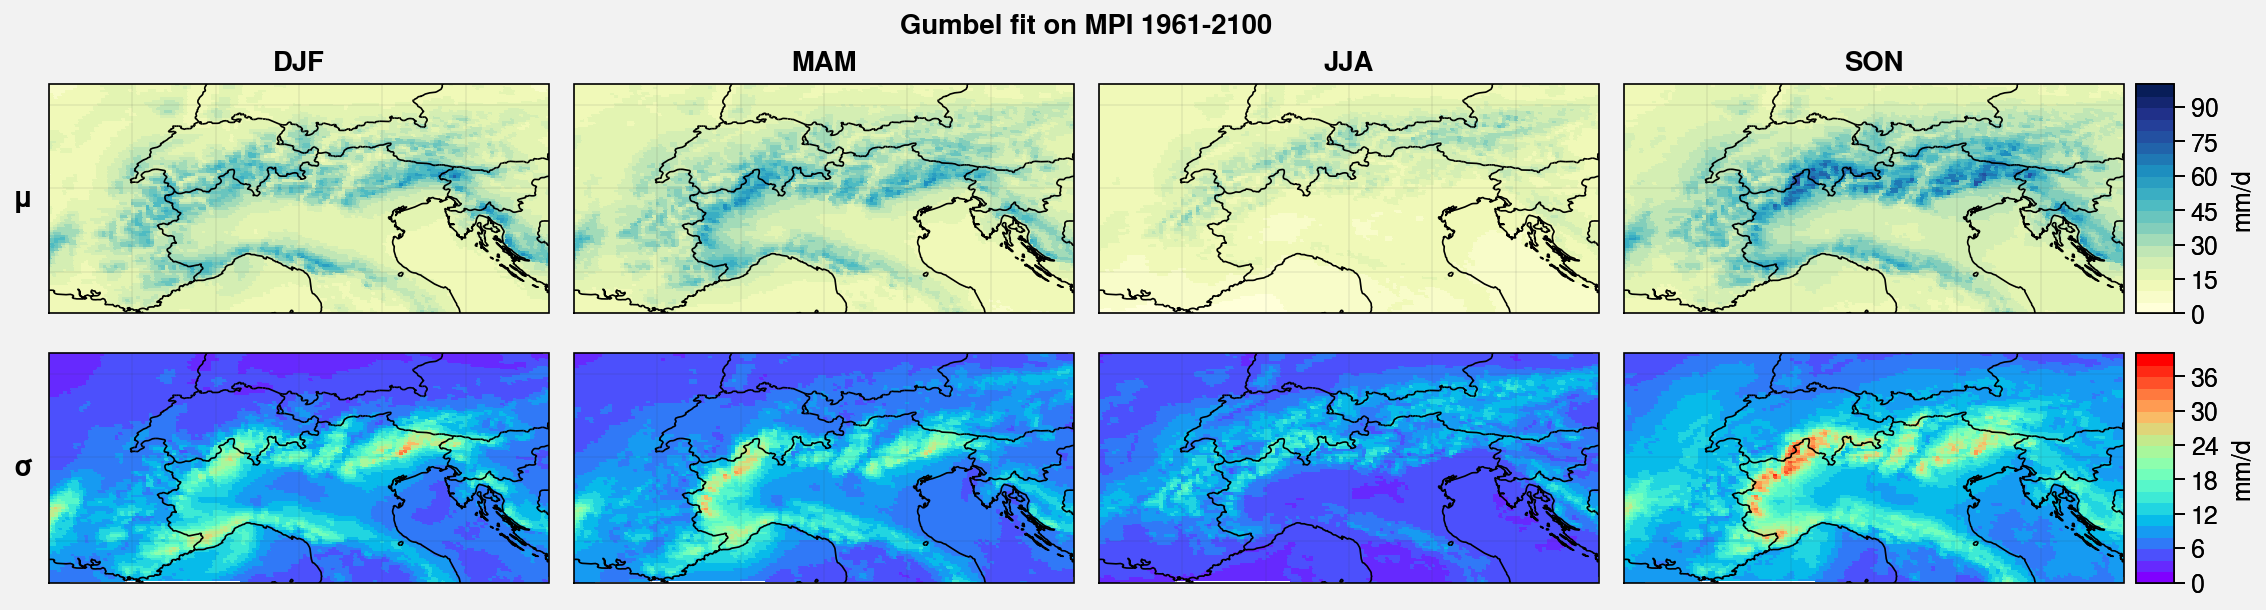

In [5]:
f, axs = pplt.subplots(proj='cyl',ncols=4, nrows=2)
for i in range(4):
    cb_μ = axs[i].pcolormesh(lon,lat,season_mu_sig[i,:,:,0],levels=np.linspace(0,100,21),cmap='YlGnBu')
    cb_σ = axs[i+4].pcolormesh(lon,lat,season_mu_sig[i,:,:,1],levels=np.linspace(0,40,21),cmap='rainbow')
f.colorbar(cb_μ, ax=axs[3],label= 'mm/d')
f.colorbar(cb_σ, ax=axs[7],label= 'mm/d')
axs.format(**multiplot_format,suptitle='Gumbel fit on MPI 1961-2100',collabels=['DJF','MAM','JJA', 'SON'],rowlabels=['μ','σ'])

In [6]:
@njit()
def nelder_mead(f, x_start ,args=(),
                step=0.1, no_improve_thr=1e-8,
                no_improv_break=10, max_iter=200,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        Pure Python/Numpy implementation of the Nelder-Mead algorithm.
        Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
        https://www.youtube.com/watch?v=vOYlVvT3W80
        
        
        @param f (function): function to minimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score, iterations)
    '''

    # init
    dim = len(x_start)
    prev_best = f(x_start, *args)
    no_improv = 0
    
    points = np.zeros((dim+1,dim))
    scores = np.zeros((dim+1))
    
    points[0]=x_start ; scores[0]=prev_best
    
    for i in range(1,dim+1):
        points[i] = np.copy(x_start)
        points[i,i-1] += step
        scores[i] = f(points[i], *args)

    # simplex iter
    iters = 0
    # break after max_iter
    while iters < max_iter:
        iters += 1
        
        # order
        ss = np.argsort(scores)
        points = points[ss]
        scores = scores[ss]
        best = scores[0] 
        

        # break after no_improv_break iterations with no improvement
        # print( '...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return points[0],scores[0],iters

        # centroid
        x0 = np.sum(points[:-1],axis=0)/dim
        # reflection
        xr = x0 + alpha*(x0 - points[-1])
        rscore = f(xr, *args)
        if scores[0] <= rscore < scores[-2]:
            points[-1] = xr
            scores[-1] = rscore
            continue

        # expansion
        if rscore < scores[0]:
            xe = x0 + gamma*(x0 - points[-1])
            escore = f(xe, *args)
            if escore < rscore:
                points[-1] = xe
                scores[-1] = escore
                continue
            else:
                points[-1] = xr
                scores[-1] = rscore
                continue

        # contraction
        xc = x0 + rho*(x0 - points[-1])
        cscore = f(xc, *args)
        if cscore < scores[-1]:
            points[-1] = xc
            scores[-1] = cscore
            continue

        # reduction
        for i in range(1,dim+1):
            points[i] = points[0] + sigma*(points[i] - points[0])
            scores[i] = f(points[i], *args)
        
    return points[0],scores[0],iters

In [7]:
### GEV fit
@njit()
def gev_nllh(params,x):
    μ,σ,ξ = params
    if ξ==0.:
        return gumbel_nllh(params[:2],x)
    a = 1+ξ*(x-μ)/σ
    a[a<0.001]=0.001
    nllhs = np.log(σ) + (1+1/ξ)*np.log(a) + a**(-1/ξ)
    nllhs[a==0.001] = 100
    return np.sum(nllhs)

@njit()
def fit_gev(x):
    μ,σ = fit_gumbel(x)
    return nelder_mead(gev_nllh, np.array([μ,σ,0.]),args=(x,),step=0.05,no_improve_thr=1e-6)[0]
    
@njit(parallel=True)
def seasonal_gev(les_season_max):
    nt,ns,nlat,nlon = np.shape(les_season_max)
    season_mu_sig_xi = np.zeros((ns,nlat,nlon,3))
    season_nllh = np.zeros((ns,nlat,nlon))
    for s in prange(ns):
        for j in prange(nlat):
            for i in prange(nlon):
                season_mu_sig_xi[s,j,i] = fit_gev(les_season_max[:,s,j,i])
                season_nllh[s,j,i] = gev_nllh(season_mu_sig_xi[s,j,i],les_season_max[:,s,j,i])
    return season_mu_sig_xi,season_nllh

In [8]:
season_mu_sig_xi,season_nllh_gev = seasonal_gev(les_season_max)

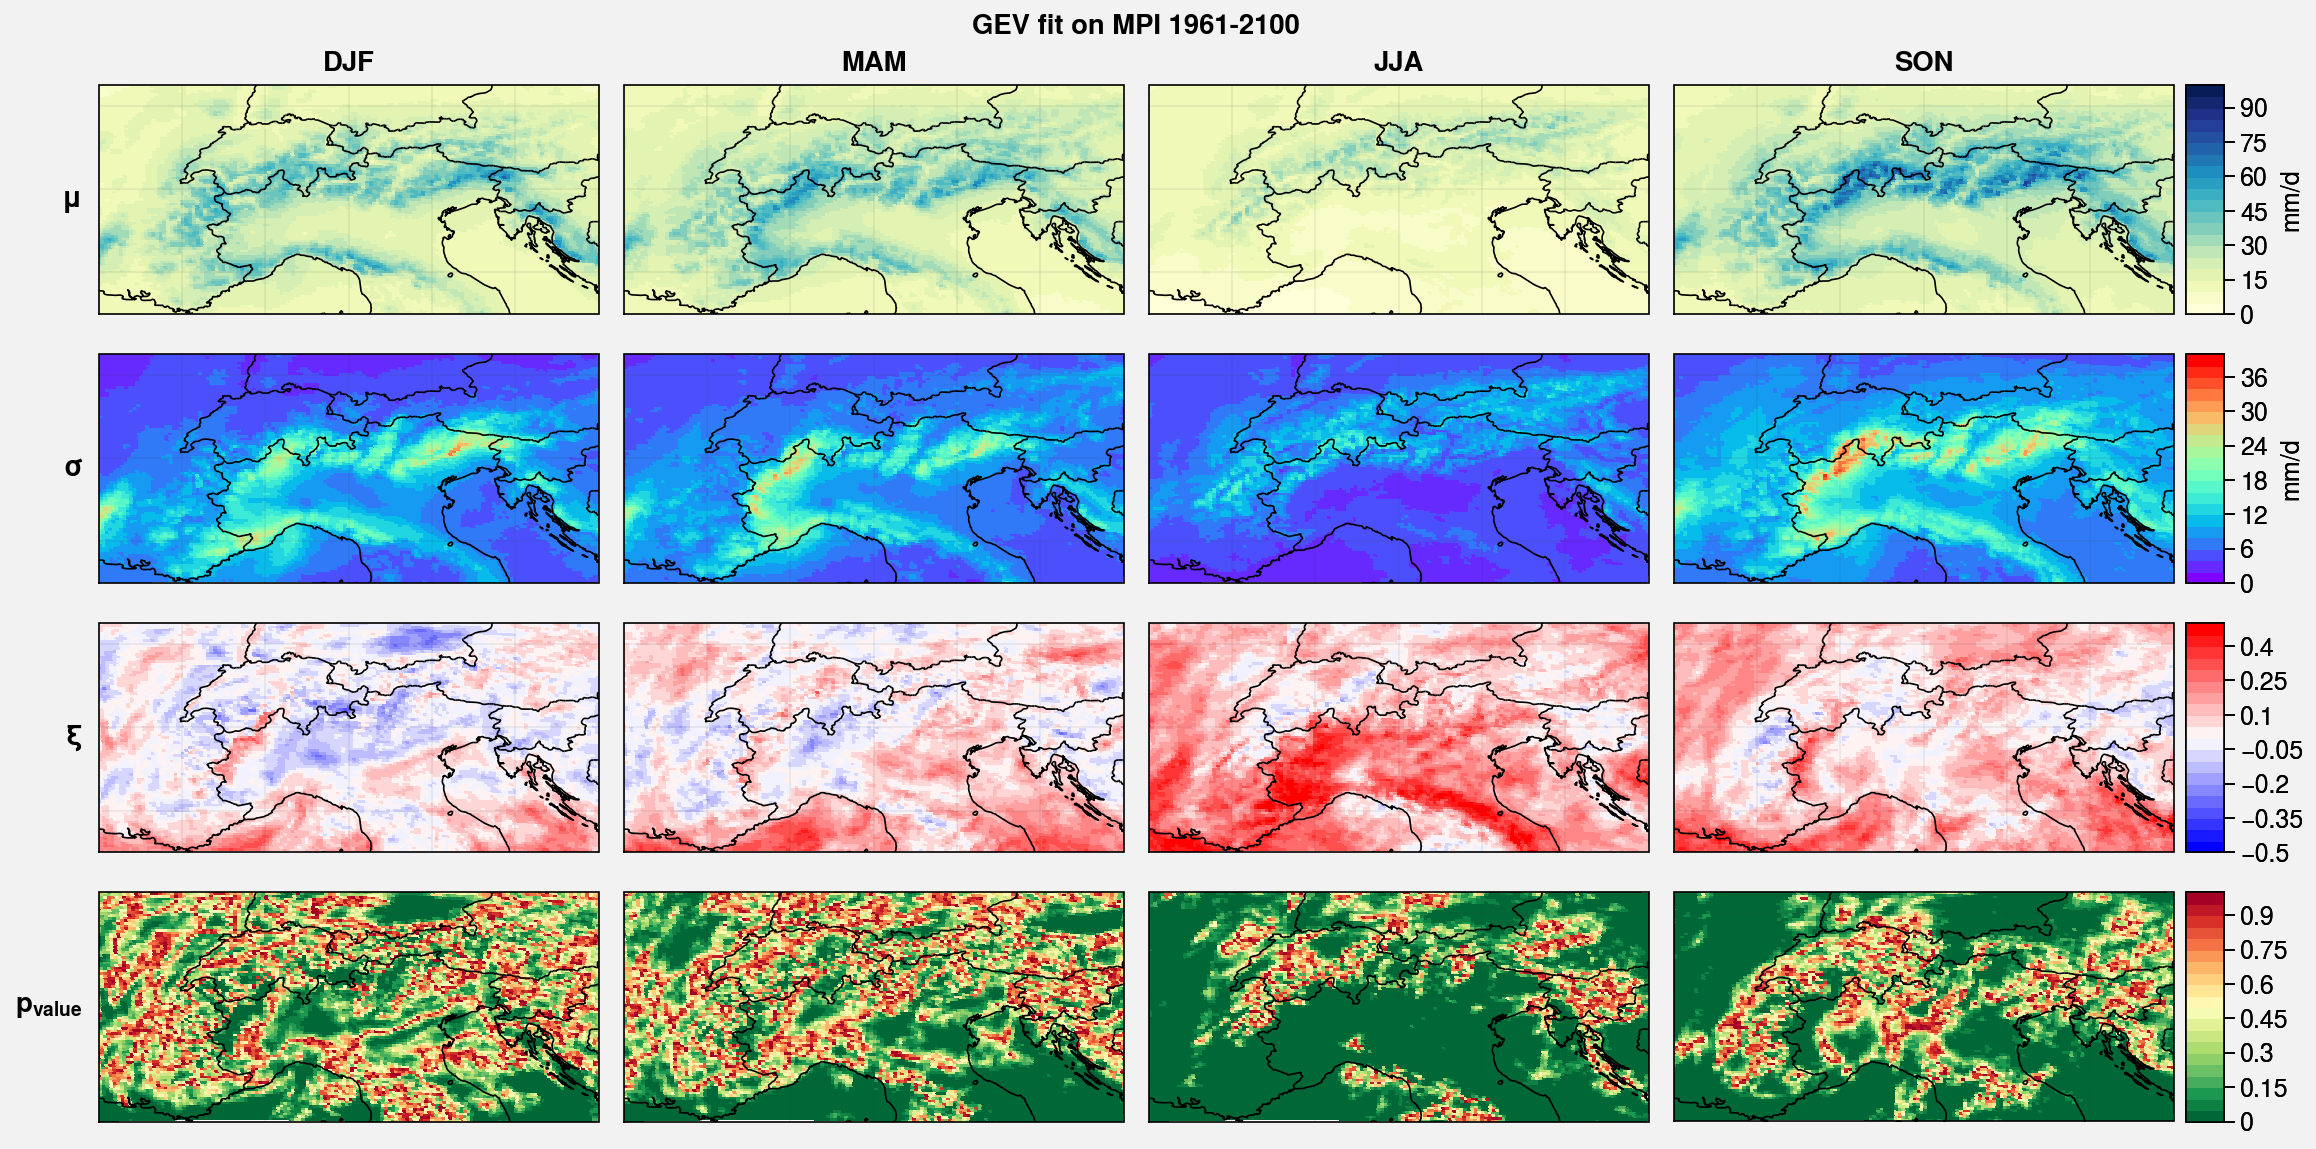

In [9]:
f, axs = pplt.subplots(proj='cyl',ncols=4, nrows=4)
for i in range(4):
    cb_μ = axs[i].pcolormesh(lon,lat,season_mu_sig_xi[i,:,:,0],levels=np.linspace(0,100,21),cmap='YlGnBu')
    cb_σ = axs[i+4].pcolormesh(lon,lat,season_mu_sig_xi[i,:,:,1],levels=np.linspace(0,40,21),cmap='rainbow')
    cb_ξ = axs[i+8].pcolormesh(lon,lat,season_mu_sig_xi[i,:,:,2],levels=np.linspace(-0.5,0.5,21),cmap='bwr')
    
    pvalue = 1 - chi2.cdf(2*(season_nllh_gumbel[i,:,:]-season_nllh_gev[i,:,:]),1)
    # cb_p = axs[i+12].pcolormesh(lon,lat,pvalue,levels=np.logspace(-2,0,21),cmap='RdYlGn_r', norm=matplotlib.colors.LogNorm())
    cb_p = axs[i+12].pcolormesh(lon,lat,pvalue,levels=np.linspace(0,1,21),cmap='RdYlGn_r')
    
f.colorbar(cb_μ, ax=axs[3],label= 'mm/d')
f.colorbar(cb_σ, ax=axs[7],label= 'mm/d')
f.colorbar(cb_ξ, ax=axs[11],label= '')
f.colorbar(cb_p, ax=axs[15],label= '')
axs.format(**multiplot_format,suptitle='GEV fit on MPI 1961-2100',collabels=['DJF','MAM','JJA', 'SON'],rowlabels=['μ','σ','ξ','$p_{value}$'])

In [10]:
### NS-GEV fit
@njit()
def nsgev_nllh(params,x):
    μ0,σ0,ξ,μt,σt = params
    y = np.arange(-(len(x)-1)/2,(len(x)+1)/2)
    if ξ==0.:
        s = (x-μ0-y*μt)/(σ0+y*σt)
        return np.sum(np.log(σ0+y*σt)+s+np.exp(-s))
    
    a = 1+ξ*(x-μ0-y*μt)/(σ0+y*σt)
    a[a<0.001]=0.001
    nllhs = np.log(σ0+y*σt) + (1+1/ξ)*np.log(a) + a**(-1/ξ)
    nllhs[a==0.001] = 100
    return np.sum(nllhs)

@njit()
def nsgev_nllh_fit(params,x,gev_params):
    μt,σt = params
    μ0,σ0,ξ = gev_params
    y = np.arange(-(len(x)-1)/2,(len(x)+1)/2)
    if ξ==0.:
        s = (x-μ0-y*μt)/(σ0+y*σt)
        return np.sum(np.log(σ0+y*σt)+s+np.exp(-s))
    
    a = 1+ξ*(x-μ0-y*μt)/(σ0+y*σt)
    a[a<0.001]=0.001
    nllhs = np.log(σ0+y*σt) + (1+1/ξ)*np.log(a) + a**(-1/ξ)
    nllhs[a==0.001] = 100
    return np.sum(nllhs)

@njit()
def fit_nsgev(x):
    μ,σ,ξ = fit_gev(x)
    μt,σt = nelder_mead(nsgev_nllh_fit, np.array([0.,0.]),args=(x,np.array([μ,σ,ξ,])),step=0.1,no_improve_thr=1e-3)[0]
    return nelder_mead(nsgev_nllh, np.array([μ,σ,ξ,μt,σt]),args=(x,),step=0.001,no_improve_thr=1e-6)[0]
    
@njit(parallel=True)
def seasonal_nsgev(les_season_max):
    nt,ns,nlat,nlon = np.shape(les_season_max)
    season_mu_sig_xi_mut_sigt = np.zeros((ns,nlat,nlon,5))
    season_nllh = np.zeros((ns,nlat,nlon))
    for s in prange(ns):
        for j in prange(nlat):
            for i in prange(nlon):
                season_mu_sig_xi_mut_sigt[s,j,i] = fit_nsgev(les_season_max[:,s,j,i])
                season_nllh[s,j,i] = nsgev_nllh(season_mu_sig_xi_mut_sigt[s,j,i],les_season_max[:,s,j,i])
    return season_mu_sig_xi_mut_sigt,season_nllh


In [11]:
season_mu_sig_xi_mut_sigt,season_nllh_nsgev = seasonal_nsgev(les_season_max)

In [12]:
nsgev_MPI = season_mu_sig_xi_mut_sigt
pvalue_MPI = 1 - chi2.cdf(2*(season_nllh_gev[i,:,:]-season_nllh_nsgev[i,:,:]),2)

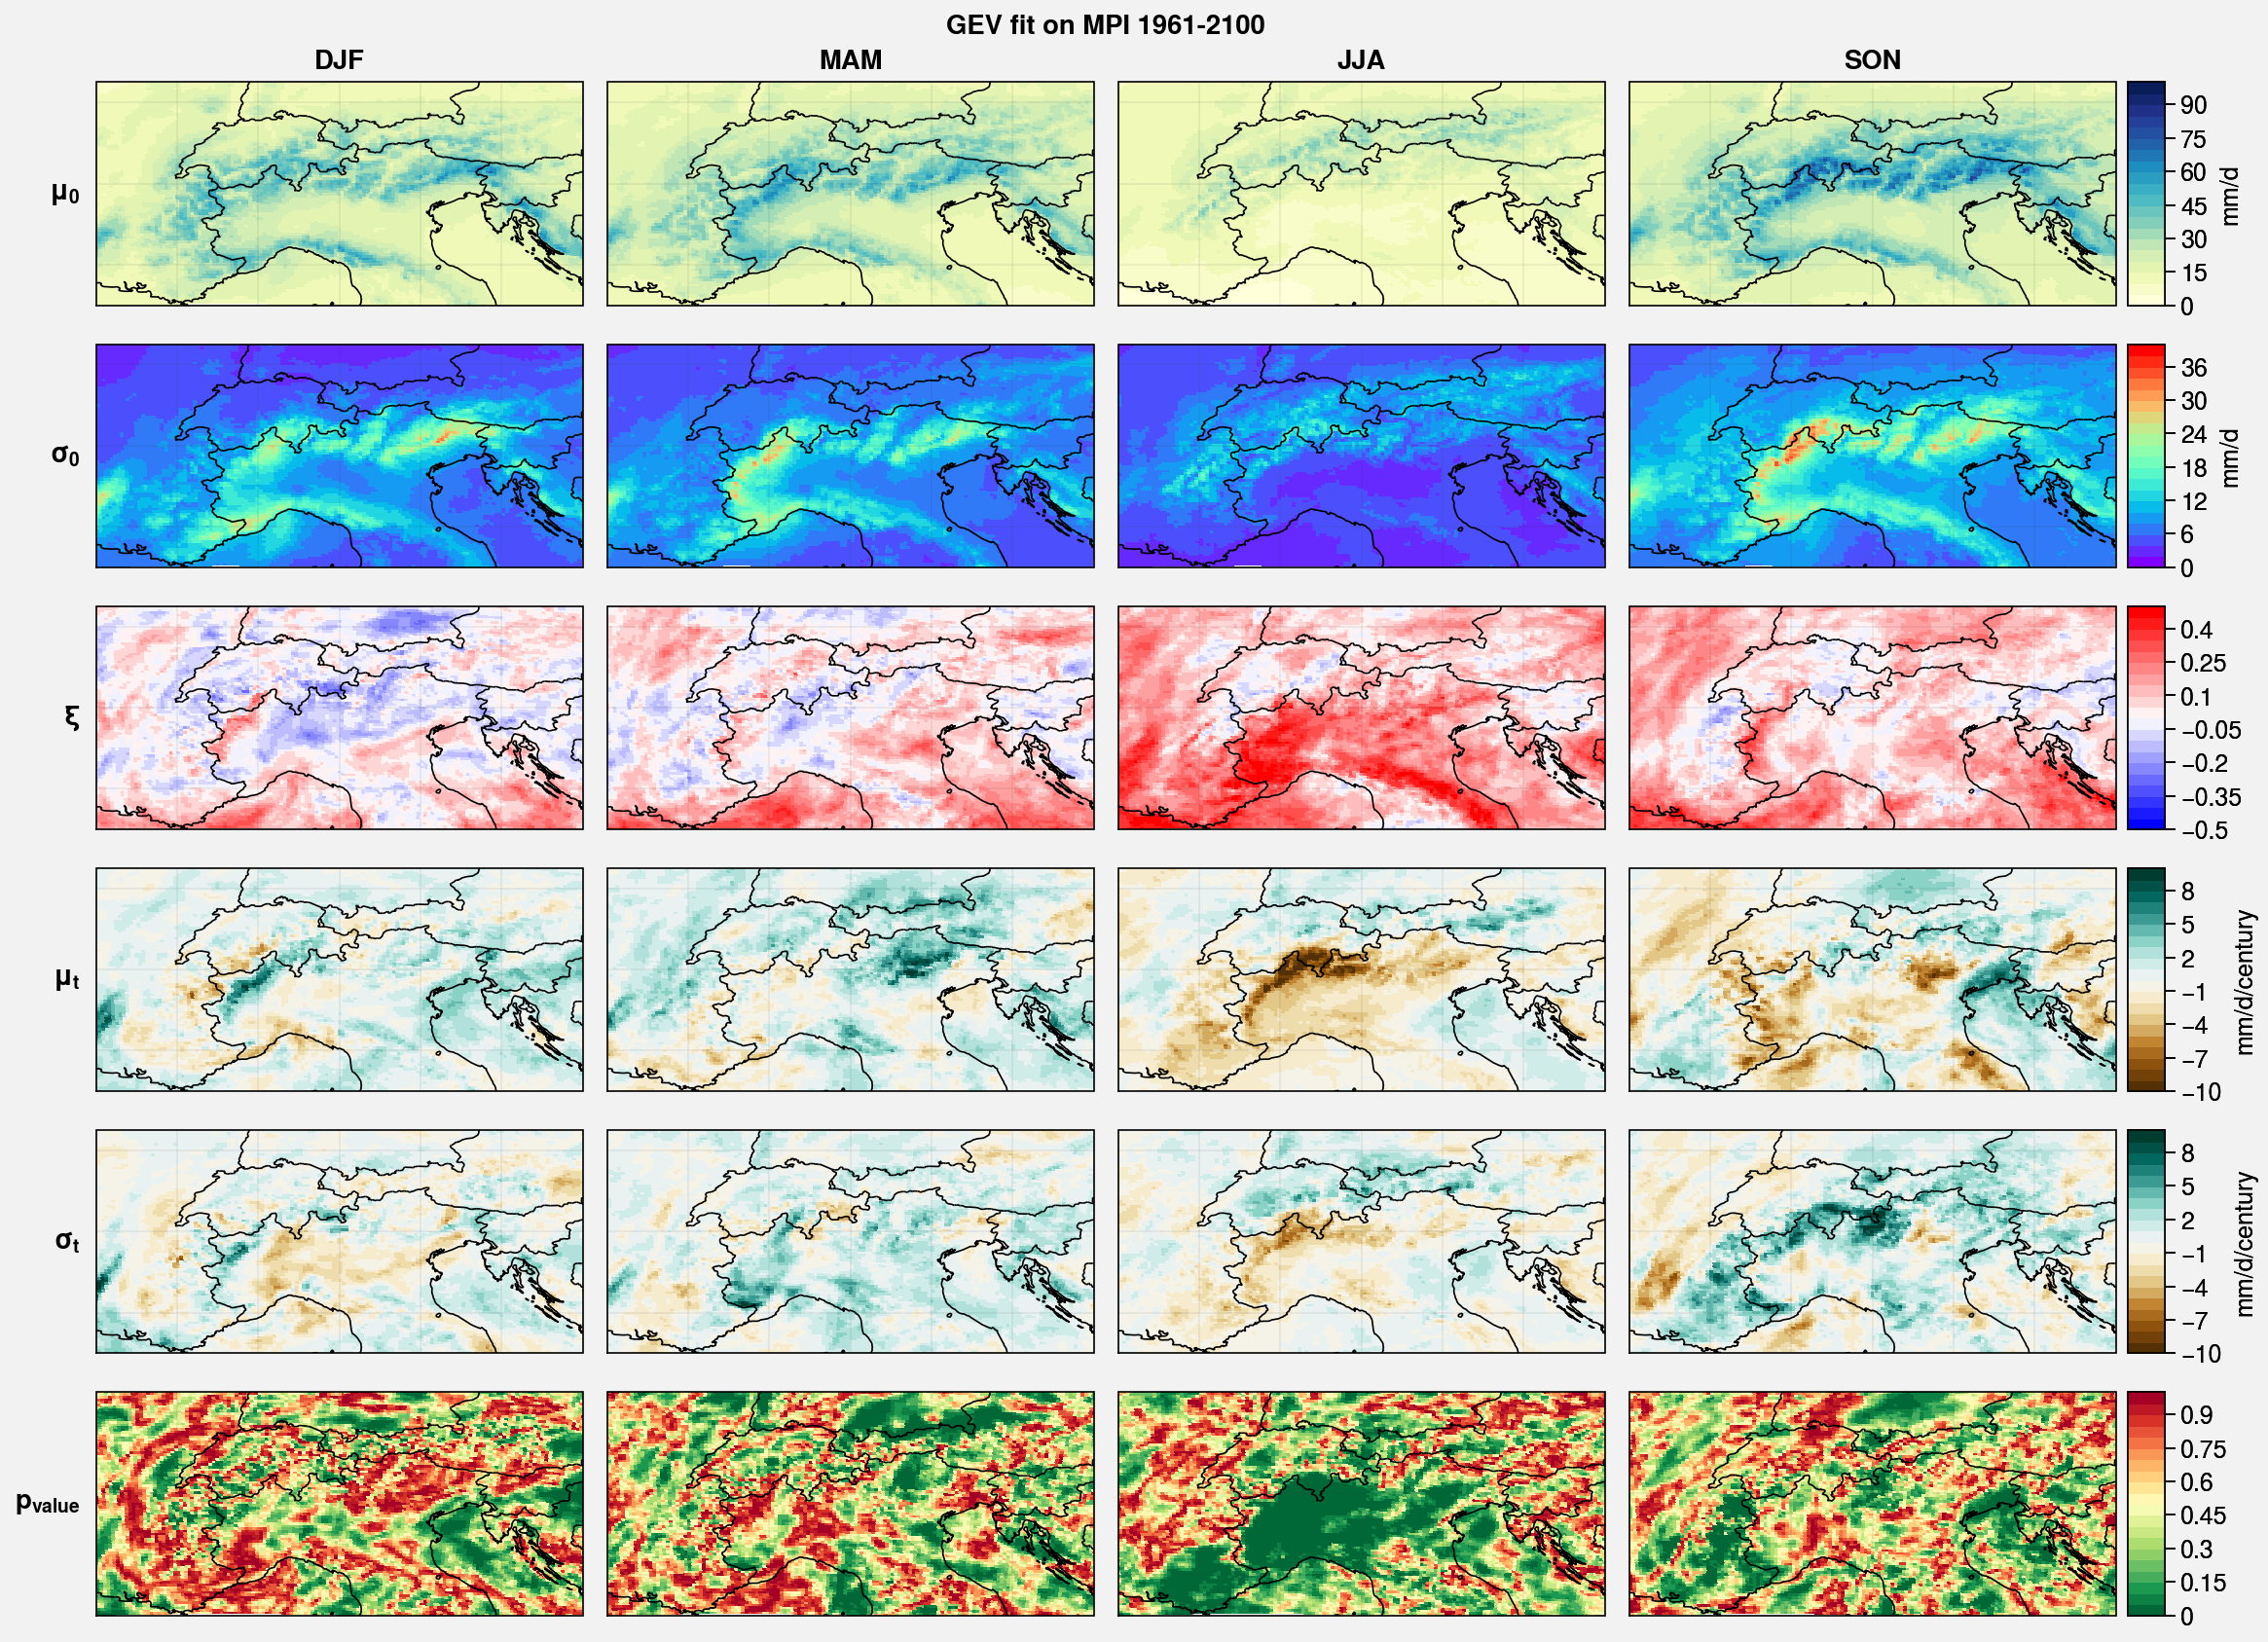

In [65]:
f, axs = pplt.subplots(proj='cyl',ncols=4, nrows=6)
for i in range(4):
    cb_μ = axs[i].pcolormesh(lon,lat,season_mu_sig_xi_mut_sigt[i,:,:,0],levels=np.linspace(0,100,21),cmap='YlGnBu')
    cb_σ = axs[i+4].pcolormesh(lon,lat,season_mu_sig_xi_mut_sigt[i,:,:,1],levels=np.linspace(0,40,21),cmap='rainbow')
    cb_ξ = axs[i+8].pcolormesh(lon,lat,season_mu_sig_xi_mut_sigt[i,:,:,2],levels=np.linspace(-0.5,0.5,21),cmap='bwr')
    
    cb_μt = axs[i+12].pcolormesh(lon,lat,100*season_mu_sig_xi_mut_sigt[i,:,:,3],levels=np.linspace(-10,10,21),cmap='BrBg')
    cb_σt = axs[i+16].pcolormesh(lon,lat,100*season_mu_sig_xi_mut_sigt[i,:,:,4],levels=np.linspace(-10,10,21),cmap='BrBg')
    # print(np.any(season_nllh_gev[i,:,:]-season_nllh_nsgev[i,:,:]<0))
    pvalue = 1 - chi2.cdf(2*(season_nllh_gev[i,:,:]-season_nllh_nsgev[i,:,:]),2)
    cb_p = axs[i+20].pcolormesh(lon,lat,pvalue,levels=np.linspace(0,1,21),cmap='RdYlGn_r')
    
f.colorbar(cb_μ, ax=axs[3],label= 'mm/d')
f.colorbar(cb_σ, ax=axs[7],label= 'mm/d')
f.colorbar(cb_ξ, ax=axs[11],label= '')
f.colorbar(cb_μt, ax=axs[15],label= 'mm/d/century')
f.colorbar(cb_σt, ax=axs[19],label= 'mm/d/century')
f.colorbar(cb_p, ax=axs[23],label= '')
axs.format(**multiplot_format,suptitle='GEV fit on MPI 1961-2100',collabels=['DJF','MAM','JJA', 'SON'],rowlabels=['$μ_0$','$σ_0$','ξ','$μ_t$','$σ_t$','$p_{value}$'])

In [ ]:
season_mu_sig_xi,season_nllh_gev = seasonal_gev(les_season_max)
season_mu_sig_xi_mut_sigt,season_nllh_nsgev = seasonal_nsgev(les_season_max)
nsgev_ECE = season_mu_sig_xi_mut_sigt
pvalue_ECE = 1 - chi2.cdf(2*(season_nllh_gev[i,:,:]-season_nllh_nsgev[i,:,:]),2)

In [8]:
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_E-OBS/les_season_max.npy')
print(np.shape(les_season_max))

ds = xr.open_dataset('/home/philinat/Stage-M2/rx1day_seas_0.1deg_reg_ens_median_E-OBSv23.1e.nc')
lon,lat = np.meshgrid(ds.longitude,ds.latitude)
print(np.shape(lon))
lon = lon[177:240,280:405]
lat = lat[177:240,280:405]
print(np.shape(lon))

(71, 4, 63, 125)
(465, 705)
(63, 125)


In [9]:
season_mu_sig,season_nllh_gumbel = seasonal_gumbel(les_season_max)

In [10]:
season_mu_sig_xi,season_nllh_gev = seasonal_gev(les_season_max)

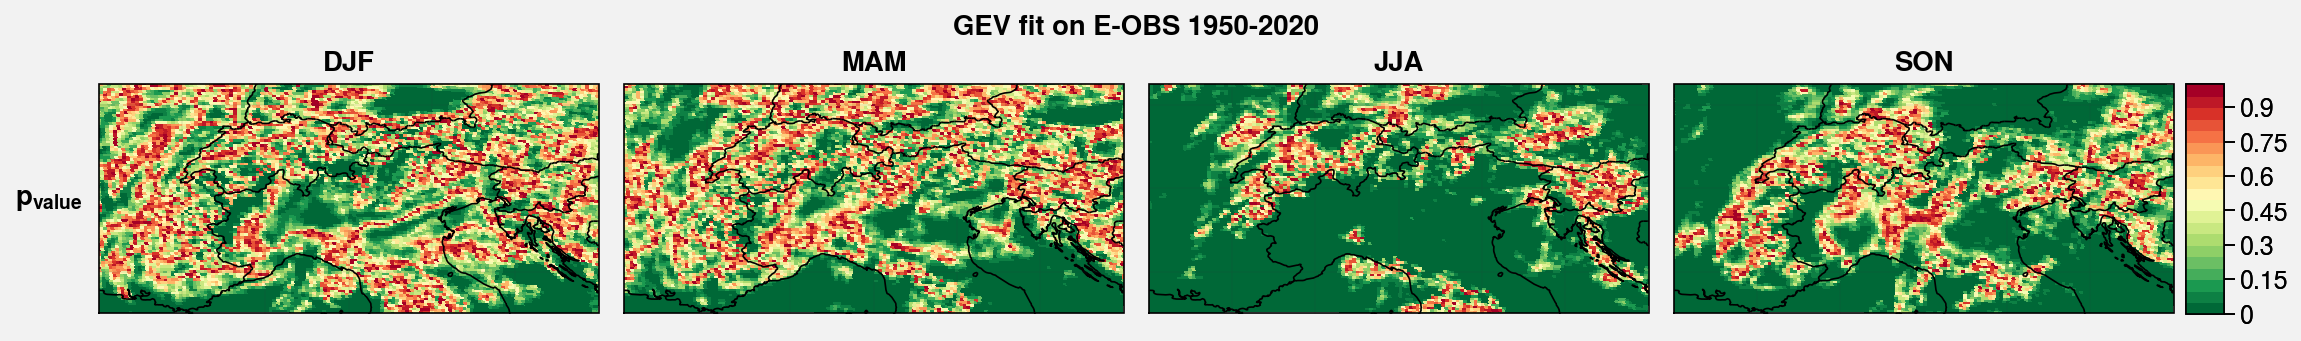

In [14]:
f, axs = pplt.subplots(proj='cyl',ncols=4, nrows=1)
for i in range(4):
    pvalue = 1 - chi2.cdf(2*(season_nllh_gumbel[i,:,:]-season_nllh_gev[i,:,:]),1)
    cb_p = axs[i].pcolormesh(lon,lat,pvalue,levels=np.linspace(0,1,21),cmap='RdYlGn_r')
    
f.colorbar(cb_p, ax=axs[3],label= '')
axs.format(**multiplot_format,suptitle='GEV fit on E-OBS 1950-2020',collabels=['DJF','MAM','JJA', 'SON'],rowlabels=['$p_{value}$'])

In [11]:
season_mu_sig_xi_mut_sigt,season_nllh_nsgev = seasonal_nsgev(les_season_max)

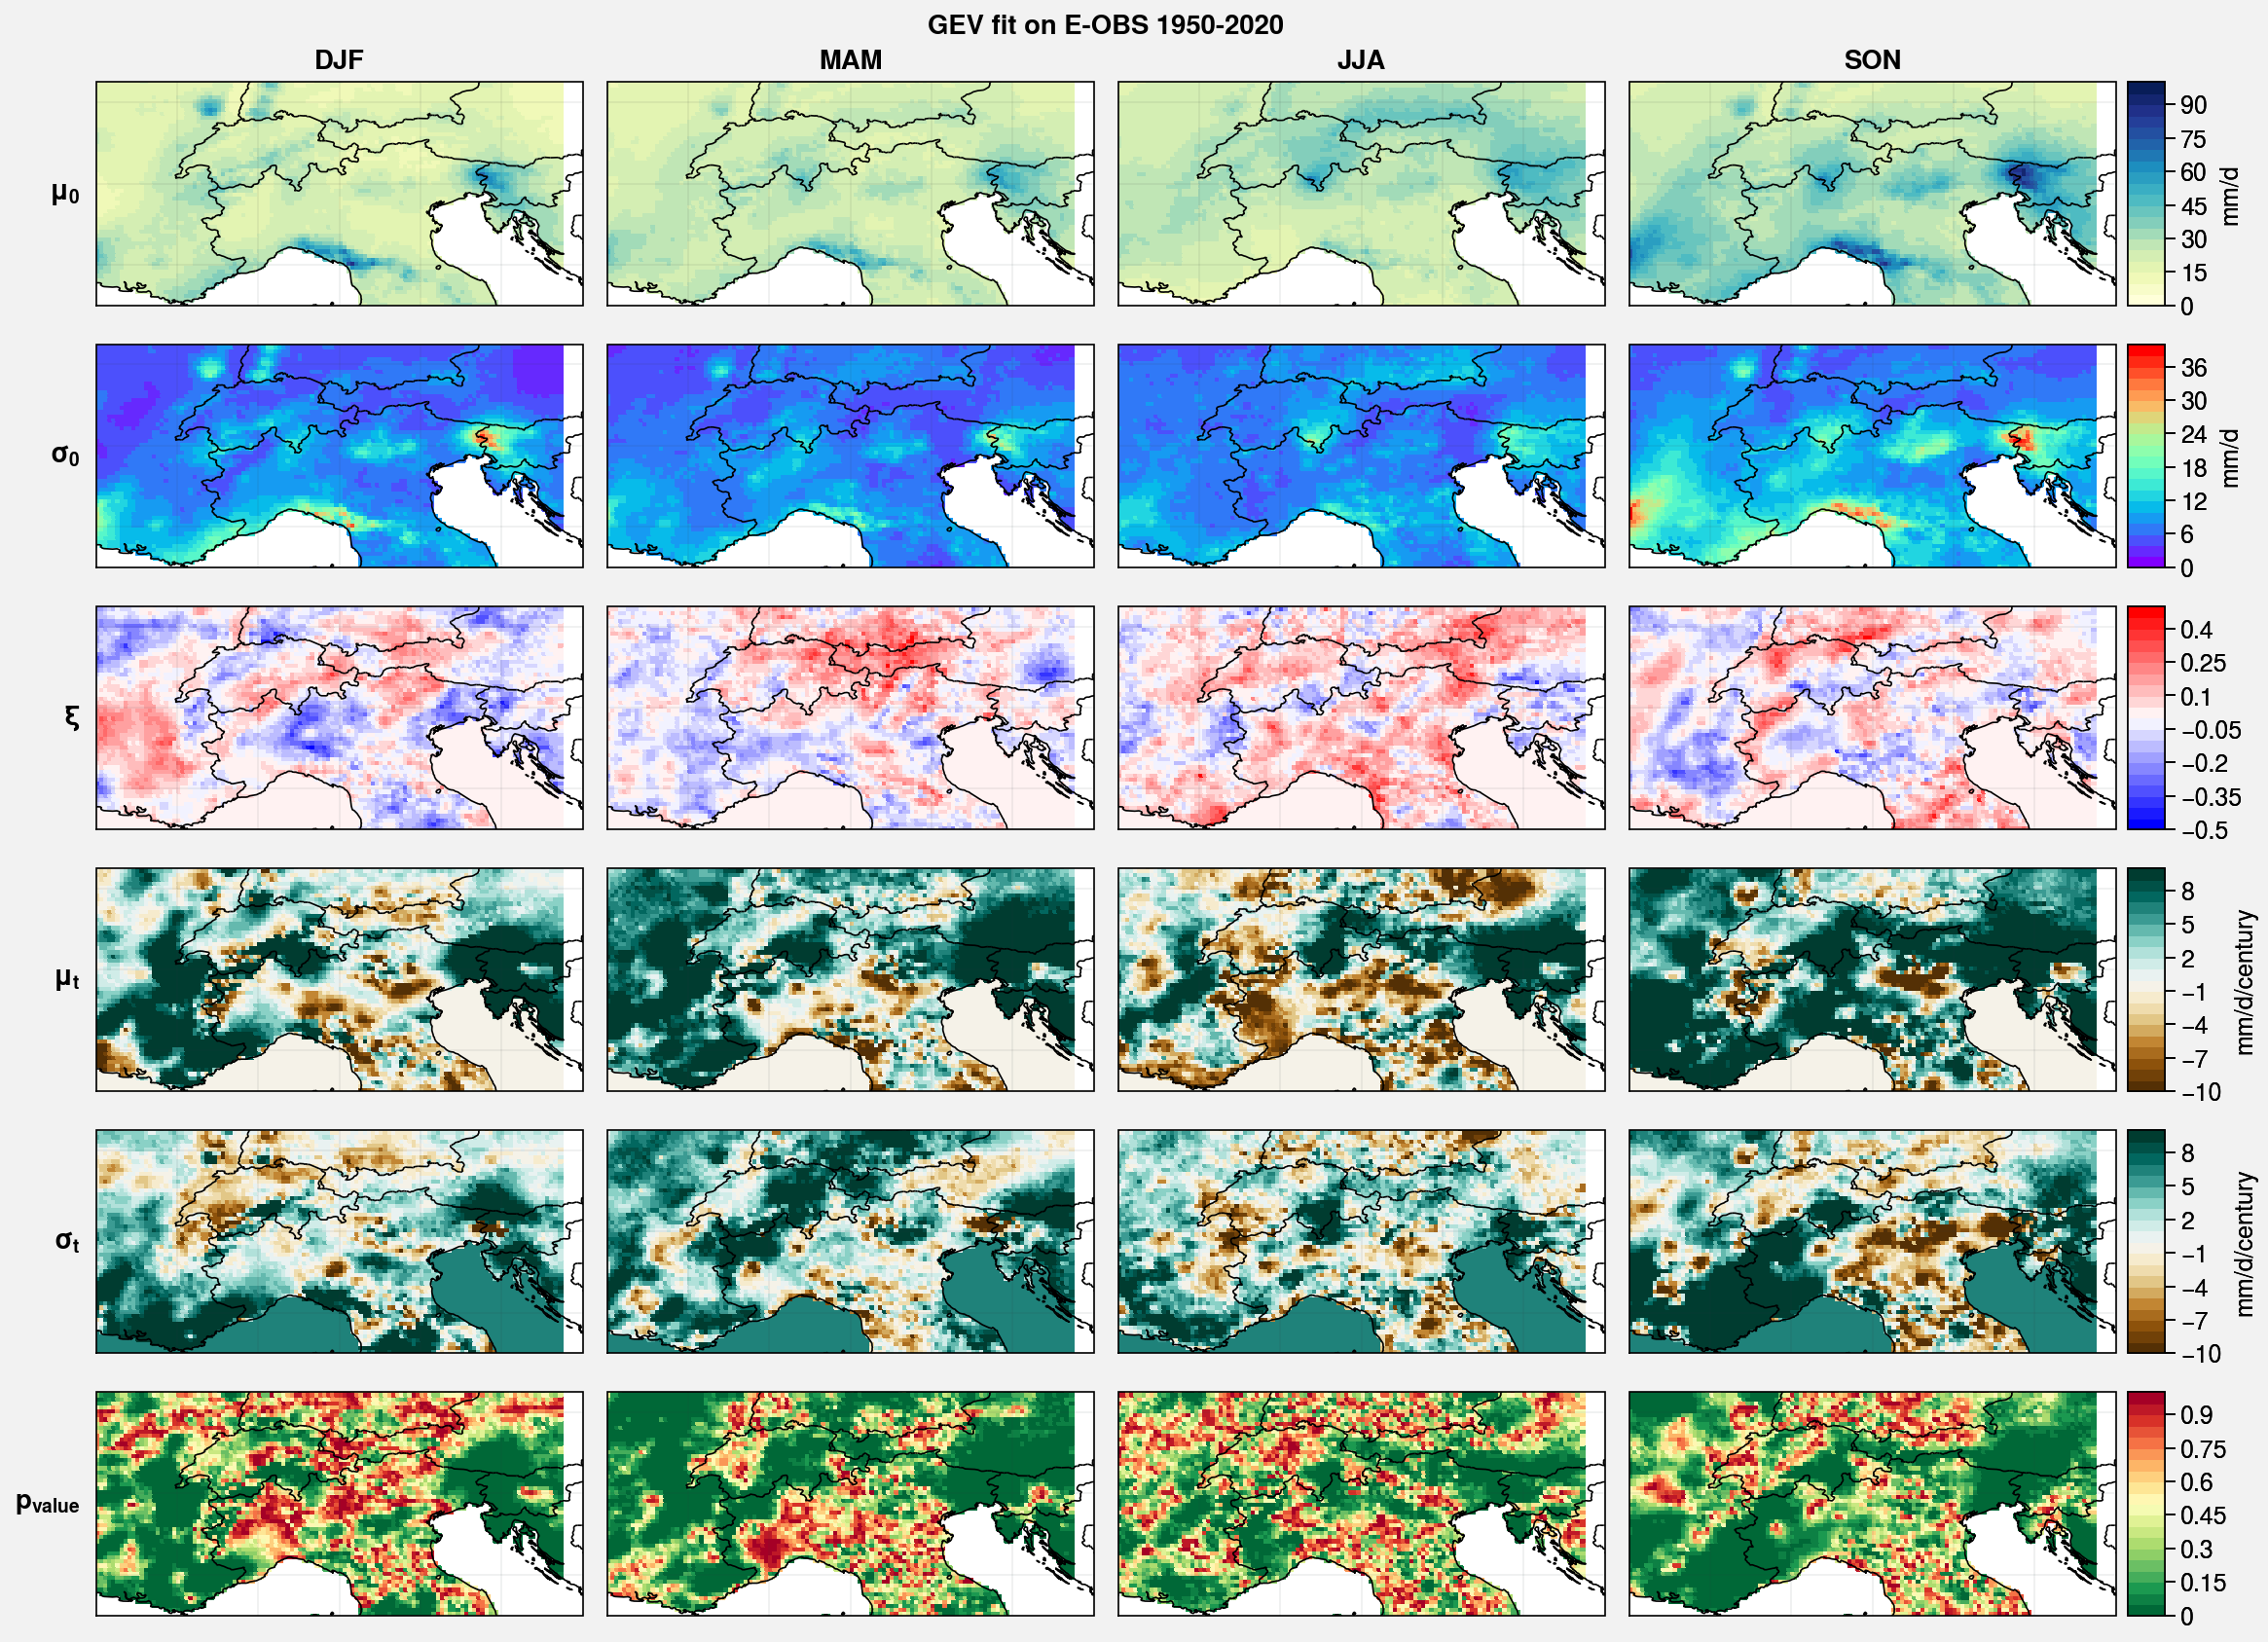

In [12]:
f, axs = pplt.subplots(proj='cyl',ncols=4, nrows=6)
for i in range(4):
    cb_μ = axs[i].pcolormesh(lon,lat,season_mu_sig_xi_mut_sigt[i,:,:,0],levels=np.linspace(0,100,21),cmap='YlGnBu')
    cb_σ = axs[i+4].pcolormesh(lon,lat,season_mu_sig_xi_mut_sigt[i,:,:,1],levels=np.linspace(0,40,21),cmap='rainbow')
    cb_ξ = axs[i+8].pcolormesh(lon,lat,season_mu_sig_xi_mut_sigt[i,:,:,2],levels=np.linspace(-0.5,0.5,21),cmap='bwr')
    
    cb_μt = axs[i+12].pcolormesh(lon,lat,100*season_mu_sig_xi_mut_sigt[i,:,:,3],levels=np.linspace(-10,10,21),cmap='BrBg')
    cb_σt = axs[i+16].pcolormesh(lon,lat,100*season_mu_sig_xi_mut_sigt[i,:,:,4],levels=np.linspace(-10,10,21),cmap='BrBg')
    # print(np.any(season_nllh_gev[i,:,:]-season_nllh_nsgev[i,:,:]<0))
    pvalue = 1 - chi2.cdf(2*(season_nllh_gev[i,:,:]-season_nllh_nsgev[i,:,:]),2)
    cb_p = axs[i+20].pcolormesh(lon,lat,pvalue,levels=np.linspace(0,1,21),cmap='RdYlGn_r')
    
    # Qt95 = params[i,:,:,3]+params[i,:,:,4]/params[i,:,:,2]*((-np.log(0.95))**(-params[i,:,:,2]) -1)
    
f.colorbar(cb_μ, ax=axs[3],label= 'mm/d')
f.colorbar(cb_σ, ax=axs[7],label= 'mm/d')
f.colorbar(cb_ξ, ax=axs[11],label= '')
f.colorbar(cb_μt, ax=axs[15],label= 'mm/d/century')
f.colorbar(cb_σt, ax=axs[19],label= 'mm/d/century')
f.colorbar(cb_p, ax=axs[23],label= '')
axs.format(**multiplot_format,suptitle='NS-GEV fit on E-OBS 1950-2020',collabels=['DJF','MAM','JJA', 'SON'],rowlabels=['$μ_0$','$σ_0$','ξ','$μ_t$','$σ_t$','$p_{value}$'])